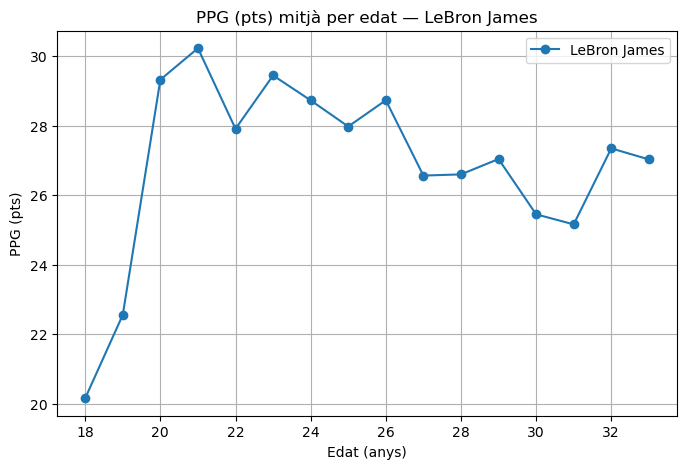

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar datasets
lebron = pd.read_csv("lebron_career.csv", sep=";")

# Funció per extreure l'edat en anys (abans del '-')
def extract_age(age_str):
    return int(str(age_str).split("-")[0])

# Afegir columna age_years
lebron["age_years"] = lebron["age"].apply(extract_age)

# Diccionari de mètriques: nom visible → columna del dataset
metrics = {
    "PPG (pts)": "pts",
}

# Generar gràfic
for title, col in metrics.items():
    plt.figure(figsize=(8,5))

    # Mitjana per edat
    lebron_avg = lebron.groupby("age_years")[col].mean()

    # Plot
    plt.plot(lebron_avg.index, lebron_avg.values, marker="o", label="LeBron James")

    plt.xlabel("Edat (anys)")
    plt.ylabel(title)
    plt.title(f"{title} mitjà per edat — LeBron James")
    plt.grid(True)
    plt.legend()
    plt.show()


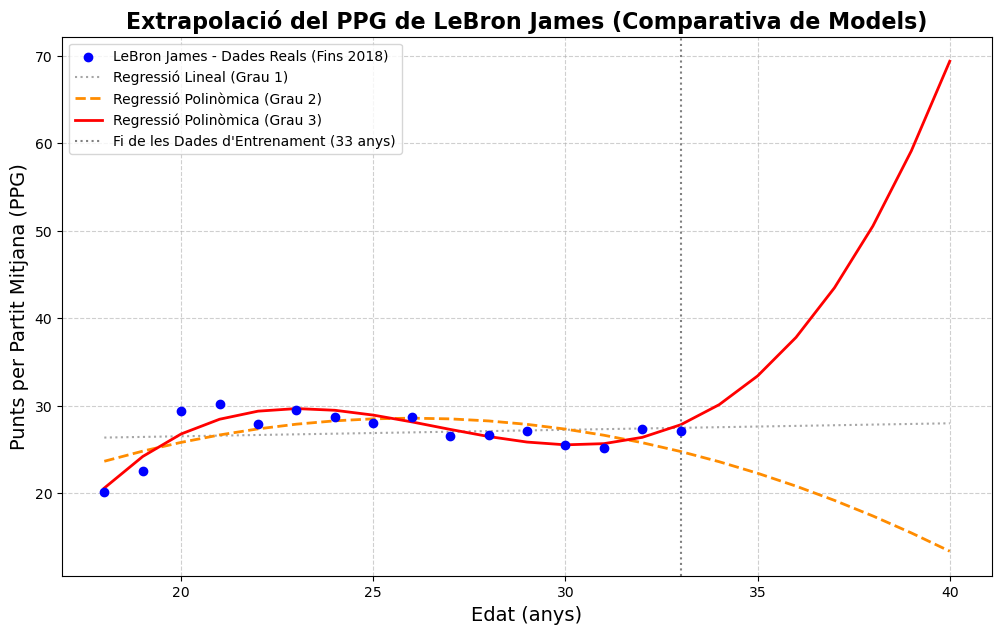


--- Prediccions Extrapolades a 39 Anys ---
Grau 1 (Lineal): 27.89 PPG
Grau 2 (Quadràtica): 15.43 PPG
Grau 3 (Cúbica): 59.12 PPG


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Carregar datasets
try:
    lebron = pd.read_csv("lebron_career.csv", sep=";")
except FileNotFoundError:
    print("Error: No es pot carregar 'lebron_career.csv'. Assegura't que l'arxiu és al directori correcte.")
    raise

# Funció per extreure l'edat en anys
def extract_age(age_str):
    if pd.isna(age_str) or not isinstance(age_str, str) or '-' not in age_str:
        return None
    try:
        return int(age_str.split("-")[0])
    except ValueError:
        return None

# Afegir columna age_years i assegurar que 'pts' és numèric
lebron["age_years"] = lebron["age"].apply(extract_age)
lebron['pts'] = pd.to_numeric(lebron['pts'], errors='coerce')

# Filtrar valors nuls
lebron.dropna(subset=["age_years", "pts"], inplace=True)

# --- 1. Preparació de les Dades per a la Regressió ---

# Agrupar per l'edat i calcular el PPG mitjà
lebron_avg = lebron.groupby("age_years")["pts"].mean().reset_index()

# Dades d'entrenament (X i Y)
X_train = lebron_avg["age_years"].values.reshape(-1, 1) 
Y_train = lebron_avg["pts"].values

# Definir les edats futures per a la predicció (Extrapolació fins als 40)
X_predict = np.arange(X_train.min(), 41).reshape(-1, 1) 
X_real_data = lebron_avg["age_years"].values.reshape(-1, 1) 

# --- 2. Entrenament dels Models ---

# Model de Grau 1 (Lineal)
model_linear = LinearRegression()
model_linear.fit(X_train, Y_train)
Y_pred_linear = model_linear.predict(X_predict)

# Model de Grau 2 (Quadràtic)
model_poly_2 = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
model_poly_2.fit(X_train, Y_train)
Y_pred_poly_2 = model_poly_2.predict(X_predict)

# Model de Grau 3 (Cúbic)
model_poly_3 = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
model_poly_3.fit(X_train, Y_train)
Y_pred_poly_3 = model_poly_3.predict(X_predict)


# --- 3. Visualització de l'Extrapolació ---

plt.figure(figsize=(12, 7))

# Dades Reals (Part d'Entrenament)
plt.scatter(X_real_data, Y_train, color='blue', label='LeBron James - Dades Reals (Fins 2018)', zorder=5)

# Corba de Predicció Lineal (Grau 1)
plt.plot(X_predict, Y_pred_linear, linestyle=':', color='gray', 
         label='Regressió Lineal (Grau 1)', alpha=0.7)

# Corba de Predicció Polinòmica (Grau 2)
plt.plot(X_predict, Y_pred_poly_2, linestyle='--', color='darkorange', 
         label='Regressió Polinòmica (Grau 2)', linewidth=2)

# Corba de Predicció Polinòmica (Grau 3)
plt.plot(X_predict, Y_pred_poly_3, linestyle='-', color='red', 
         label='Regressió Polinòmica (Grau 3)', linewidth=2)

# Línia de tall entre dades d'entrenament i predicció
max_age_train = X_train.max()
plt.axvline(x=max_age_train, color='gray', linestyle=':', label=f'Fi de les Dades d\'Entrenament ({int(max_age_train)} anys)')


# Afegir títols i etiquetes
plt.title(f'Extrapolació del PPG de LeBron James (Comparativa de Models)', fontsize=16, fontweight='bold')
plt.xlabel('Edat (anys)', fontsize=14)
plt.ylabel('Punts per Partit Mitjana (PPG)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- 4. Anàlisi dels Models (Comparativa) ---
print("\n--- Prediccions Extrapolades a 39 Anys ---")
age_39 = np.array([[39]])
print(f"Grau 1 (Lineal): {model_linear.predict(age_39)[0]:.2f} PPG")
print(f"Grau 2 (Quadràtica): {model_poly_2.predict(age_39)[0]:.2f} PPG")
print(f"Grau 3 (Cúbica): {model_poly_3.predict(age_39)[0]:.2f} PPG")

--------- RESULTATS VALIDACIÓ CREUADA ---------

Regressió Logística:
  Accuracy CV: 0.8435

Random Forest:
  Accuracy CV: 0.8362



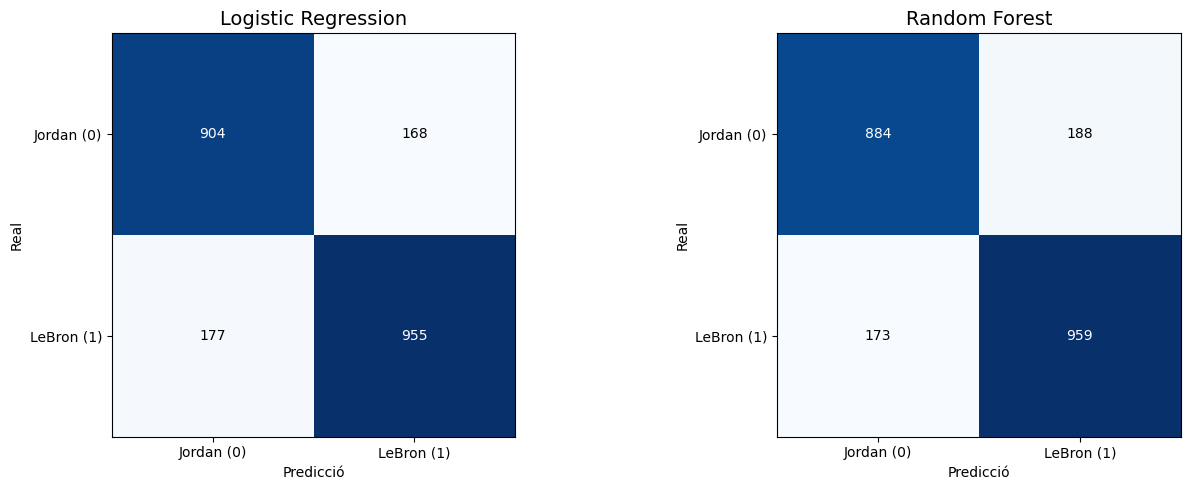

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate, cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


# ======================================================
# 1. CARREGA I TRACTAMENT INICIAL DE DADES
# ======================================================

df = pd.read_csv("careers.csv", sep=";")

# Convertir mp ("MM:SS") -> minuts decimals
def mp_to_minutes(mp_str):
    try:
        m, s = mp_str.split(":")
        return int(m) + int(s)/60
    except:
        return np.nan

df["mp"] = df["mp"].apply(mp_to_minutes)

# Convertir totes les columnes numèriques
for col in df.columns:
    if col != "player":
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Omplir NaNs de percentatges (threep, ftp)
for col in ["threep", "ftp"]:
    df[col] = df[col].fillna(df[col].mean())


# ======================================================
# 2. FEATURE ENGINEERING
# ======================================================

eps = 1e-6

df["AST_per_PTS"] = df["ast"] / (df["pts"] + eps)
df["3PT_Attempt_Ratio"] = df["threeatt"] / (df["fga"] + eps)
df["TRB_per_FGA"] = df["trb"] / (df["fga"] + eps)

df.replace([np.inf, -np.inf], np.nan, inplace=True)


# ======================================================
# 3. TRACTAMENT FINAL DE NaNs
# ======================================================

for col in df.columns:
    if col != "player":
        df[col] = df[col].fillna(df[col].mean())


# ======================================================
# 4. DEFINIR X i Y
# ======================================================

X = df.drop(columns=["player"])
Y = df["player"]


# ======================================================
# 5. ESCALAT
# ======================================================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# ======================================================
# 6. DEFINIR MODELS
# ======================================================

models = {
    "Regressió Logística": LogisticRegression(random_state=42, max_iter=2000),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=200)
}

# Trio ACCURACY com a mètrica, estan balancejats
scoring = ["accuracy"]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = {}


# ======================================================
# 7. VALIDACIÓ CREUADA (ACCURACY)
# ======================================================

print("--------- RESULTATS VALIDACIÓ CREUADA ---------\n")

for name, model in models.items():
    cv_results = cross_validate(model, X_scaled, Y, cv=kf, scoring=scoring)

    results[name] = {
        "Accuracy Mitjana": np.mean(cv_results["test_accuracy"])
    }

    print(f"{name}:")
    print(f"  Accuracy CV: {results[name]['Accuracy Mitjana']:.4f}\n")


# ======================================================
# 8. MATRIUS DE CONFUSIÓ AMB CROSS_VAL_PREDICT
# ======================================================

def plot_confusion_matrix(cm, title, ax):
    labels = ["Jordan (0)", "LeBron (1)"]
    ax.imshow(cm, cmap=plt.cm.Blues)
    ax.set_title(title, fontsize=14)
    ax.set_xticks(range(2))
    ax.set_yticks(range(2))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    thresh = cm.max() / 2
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel("Real")
    ax.set_xlabel("Predicció")


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Logistic Regression CM
preds_logreg = cross_val_predict(
    LogisticRegression(random_state=42, max_iter=2000),
    X_scaled, Y, cv=kf
)
cm_logreg = confusion_matrix(Y, preds_logreg)
plot_confusion_matrix(cm_logreg, "Logistic Regression", axes[0])

# Random Forest CM
preds_rf = cross_val_predict(
    RandomForestClassifier(random_state=42, n_estimators=200),
    X_scaled, Y, cv=kf
)
cm_rf = confusion_matrix(Y, preds_rf)
plot_confusion_matrix(cm_rf, "Random Forest", axes[1])

plt.tight_layout()
plt.show()

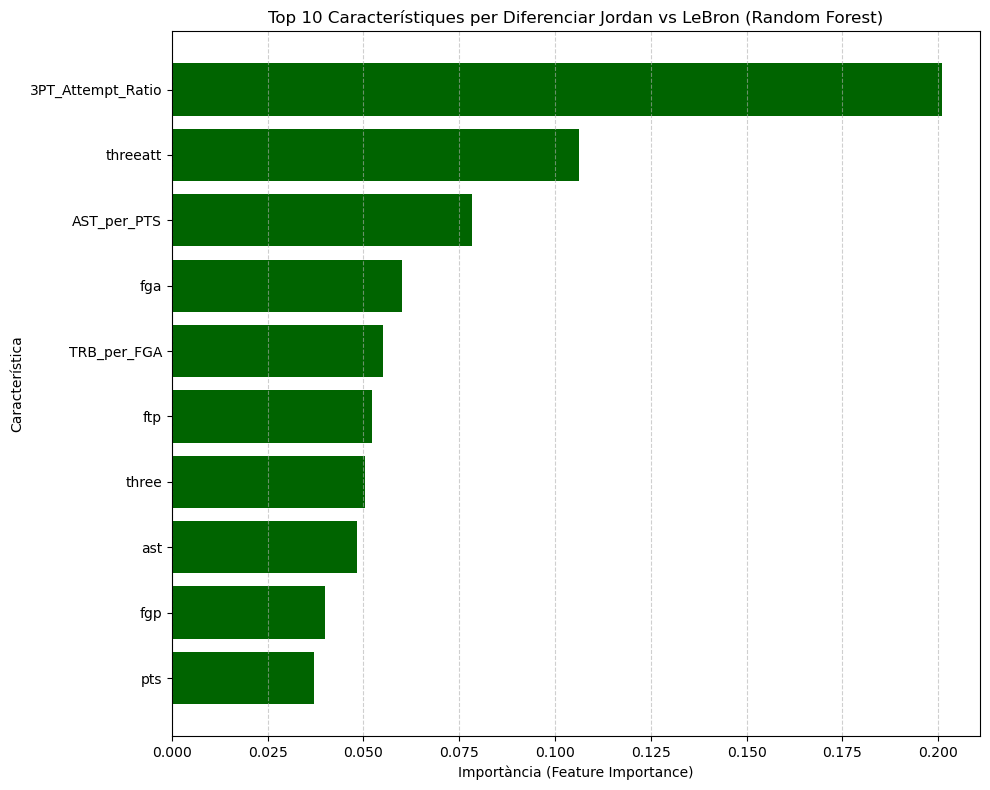


--- TOP 10 Característiques més Importants ---
Característica                 |  Importància
---------------------------------------------
3PT_Attempt_Ratio              |       0.2009
threeatt                       |       0.1064
AST_per_PTS                    |       0.0784
fga                            |       0.0600
TRB_per_FGA                    |       0.0550
ftp                            |       0.0522
three                          |       0.0503
ast                            |       0.0482
fgp                            |       0.0401
pts                            |       0.0372


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


# ======================================================
# 1. CARREGA I TRACTAMENT INICIAL DELS NaNs
# ======================================================

df = pd.read_csv("careers.csv", sep=";")

# Convertir mp ("MM:SS") -> minuts decimals
def mp_to_minutes(mp_str):
    try:
        m, s = mp_str.split(":")
        return int(m) + int(s)/60
    except:
        return np.nan

df["mp"] = df["mp"].apply(mp_to_minutes)

# Convertir totes les columnes (menys player) a numèriques
for col in df.columns:
    if col != "player":
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Omplir NaNs específics de percentatges
for col in ["threep", "ftp"]:
    df[col] = df[col].fillna(df[col].mean())


# ======================================================
# 2. FEATURE ENGINEERING (igual que al model de classificació)
# ======================================================

eps = 1e-6

df["AST_per_PTS"] = df["ast"] / (df["pts"] + eps)
df["3PT_Attempt_Ratio"] = df["threeatt"] / (df["fga"] + eps)
df["TRB_per_FGA"] = df["trb"] / (df["fga"] + eps)

df.replace([np.inf, -np.inf], np.nan, inplace=True)


# ======================================================
# 3. TRACTAMENT FINAL DE NaNs
# ======================================================

for col in df.columns:
    if col != "player":
        df[col] = df[col].fillna(df[col].mean())


# ======================================================
# 4. DEFINIR X I Y
# ======================================================

X = df.drop(columns=["player"])
Y = df["player"]


# ======================================================
# 5. ESCALAT DE DADES
# ======================================================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# ======================================================
# 6. ENTRENAMENT DEL RANDOM FOREST (per importància)
# ======================================================

rf_model = RandomForestClassifier(random_state=42, n_estimators=200)
rf_model.fit(X_scaled, Y)


# ======================================================
# 7. IMPORTÀNCIA DE LES FEATURES
# ======================================================

feature_names = X.columns
importances = rf_model.feature_importances_

feature_importances_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

top_10 = feature_importances_df.head(10)


# ======================================================
# 8. GRÀFIC DE LES 10 FEATURES MÉS IMPORTANTS
# ======================================================

plt.figure(figsize=(10, 8))
plt.barh(top_10["Feature"], top_10["Importance"], color="darkgreen")
plt.xlabel("Importància (Feature Importance)")
plt.ylabel("Característica")
plt.title("Top 10 Característiques per Diferenciar Jordan vs LeBron (Random Forest)")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# ======================================================
# 9. TAULA AMB LES 10 MILLORS FEATURES
# ======================================================

print("\n--- TOP 10 Característiques més Importants ---")
print(f"{'Característica':<30} | {'Importància':>12}")
print("-" * 45)

for _, row in top_10.iterrows():
    print(f"{row['Feature']:<30} | {row['Importance']:>12.4f}")
